<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/df_imputed_week_shift_start_2017_added_holiday_weekends", index_col = 0, parse_dates = True)

In [0]:
cols = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit", "holiday", "weekend"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

In [0]:
# Make speed_limit binary
import numpy as np
df['speed_limit'] =  np.where(df.speed_limit > 110, 1, 0)

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "10T", method_speed = np.mean, method_flow = np.sum):
    copied = df.copy()
    copied = copied.resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow,
           "speed_limit": np.median, "holiday": np.median, "weekend": np.median})
    return copied

In [0]:
r_df = resample_df(df, freq = "15T")

In [0]:
r_df.head()

,speed,speed_-2,speed_-1,speed_+1,speed_+2,flow,flow_-2,flow_-1,flow_+1,flow_+2,speed_limit,holiday,weekend
2017-01-01 00:00:00,115.833333,116.584444,116.116667,116.103333,115.532222,280.0,274.0,276.0,282.0,283.0,1,1,1
2017-01-01 00:15:00,116.972222,116.926667,116.928889,117.613333,117.286667,410.0,413.0,407.0,415.0,421.0,1,1,1
2017-01-01 00:30:00,117.806667,117.936667,117.385556,118.200000,117.883333,504.0,504.0,510.0,509.0,516.0,1,1,1
2017-01-01 00:45:00,116.103333,116.760000,115.980000,116.275556,115.808889,508.0,501.0,508.0,503.0,492.0,1,1,1
2017-01-01 01:00:00,116.484444,117.096667,116.873333,115.977778,116.284444,444.0,457.0,445.0,439.0,439.0,1,1,1


### Train test split. The final year is reserved for testing. (Val will be relevant later?)

In [0]:
def train_val_test_split(df, val_year, test_year):
    # train, test
    return df[(df.index.year < val_year)].copy(), df[df.index.year == val_year].copy(), df[df.index.year == test_year].copy()

In [0]:
train, val, test = train_val_test_split(r_df, 2018, 2019)

In [0]:
import numpy as np
def log_transform(df):
    copy = df.copy()
    return np.log(copy.iloc[:, :-3].replace(0, 1e-15)).join(df.iloc[:, -3:], how = 'inner')

# Log transform. First set 0s to very low value 'cause you can't log 0.
train_log = log_transform(train)
val_log = log_transform(val)
test_log = log_transform(test)

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# ML
import pdb
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [0]:
X_train = np.array(train_log)
y_train = np.array(train_log.speed)

X_val = np.array(val_log)
y_val = np.array(val_log.speed)

X_test = np.array(test_log)
y_test = np.array(test_log.speed)

In [0]:
lookback = int(24 * (60 / 15))

train_gen = TimeseriesGenerator(data = X_train, targets = y_train, length = lookback)
val_gen = TimeseriesGenerator(data = X_val, targets = y_val, length = lookback)
test_gen = TimeseriesGenerator(data = X_test, targets = y_test, length = lookback)

In [0]:
x, y = train_gen[0]

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
############## Define Neural Network Class ##############
class neural_net(tf.keras.Model):
    def __init__(self, lookback = 24, regularization = 1e-6): #You can choose to have more input here! E.g. number of neurons.
        super(neural_net, self).__init__()

        #Define l2 regularization
        self.regularization = regularization
        regu = tf.keras.regularizers.l2(self.regularization)

        self.lookback = lookback

        #Define discrete feature layers
        self.discrete_flatten = tf.keras.layers.Flatten()
        self.discrete_prelu1 = tf.keras.layers.PReLU()
        self.discrete_bnorm1 = tf.keras.layers.BatchNormalization()
        self.discrete_dense1 = tf.keras.layers.Dense(32, activation = 'linear', use_bias = True, kernel_regularizer =  regu)
        self.discrete_prelu2 = tf.keras.layers.PReLU()

        #Define time feature Layers
        #Time 1
        self.time1_conv1 = tf.keras.layers.Conv1D(filters = 32, kernel_size = (1), use_bias = True, kernel_regularizer = regu)
        self.time1_prelu1 = tf.keras.layers.PReLU()
        self.time1_bnorm1 = tf.keras.layers.BatchNormalization()
        self.time1_lstm1 = tf.keras.layers.LSTM(32, dropout = 0.1, recurrent_dropout = 0.5, input_shape = (self.lookback, 32), kernel_regularizer = regu)
        self.time1_prelu2 = tf.keras.layers.PReLU()

        #Time 2
        self.time2_conv1 = tf.keras.layers.Conv1D(filters = 32, kernel_size = (1), use_bias = True, kernel_regularizer = regu)
        self.time2_prelu1 = tf.keras.layers.PReLU()
        self.time2_bnorm1 = tf.keras.layers.BatchNormalization()
        self.time2_lstm1 = tf.keras.layers.LSTM(32, dropout = 0.1, recurrent_dropout = 0.5, input_shape = (self.lookback, 32), kernel_regularizer = regu)
        self.time2_prelu2 = tf.keras.layers.PReLU()

        #Define Merged layers
        self.dense1 = tf.keras.layers.Dense(32, use_bias = True, kernel_regularizer = regu)
        self.prelu1 = tf.keras.layers.PReLU()
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(1, activation = 'linear', use_bias = True, kernel_regularizer = regu)

    #Define the forward propagation
    def call(self, inputs):
        
        #Split time and discrete inputs
        x_time = inputs[:, :, :-3]
        x_discrete = inputs[:, :, -3:]

        #Run discrete layers
        x_discrete = self.discrete_flatten(x_discrete)
        x_discrete = self.discrete_prelu1(x_discrete)
        x_discrete = self.discrete_bnorm1(x_discrete)
        x_discrete = self.discrete_dense1(x_discrete)
        x_discrete = self.discrete_prelu2(x_discrete)

        #Run time layers
        x_time1 = self.time1_conv1(x_time)
        x_time1 = self.time1_prelu1(x_time1)
        x_time1 = self.time1_bnorm1(x_time1)
        x_time1 = self.time1_lstm1(x_time1)
        x_time1 = self.time1_prelu2(x_time1)
        
        x_time2 = self.time2_conv1(x_time)
        x_time2 = self.time2_prelu1(x_time2)
        x_time2 = self.time2_bnorm1(x_time2)
        x_time2 = self.time2_lstm1(x_time2)
        x_time2 = self.time2_prelu2(x_time2)

        #Concat layers
        pdb.set_trace()
        x = tf.concat([x_time1, x_time2, x_discrete], axis = 1)
        x = self.dense1(x)
        x = self.prelu1(x)
        x = self.bnorm1(x)
        x = self.dense2(x)
        
        #Return output
        return x

#Create an instance of you neural network model
model = neural_net(lookback = 24 * 4, regularization = 1e-6)

#Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

#Define loss function
mse_loss_fn = tf.keras.losses.MeanSquaredError()

#Compile model
model.compile(optimizer = optimizer, loss = mse_loss_fn)

#Train model
history = model.fit(train_gen, validation_data = val_gen, epochs = 20)
train_loss, val_loss = history.history['loss'], history.history['val_loss']

#Evaluate on test set
test_loss = model.evaluate(test_gen)
print('Test Loss: ' + str(test_loss))

#Plot test and validation loss
plt.figure(figsize = (5, 5))
plt.semilogy(train_loss, lw = 1.4)
plt.semilogy(val_loss, lw = 1.4)
plt.legend(['Train Loss', 'Val Loss'])
plt.grid(True)
plt.title('Train Loss')
plt.show()

> /tmp/tmpwh_2ddzp.py(28)tf__call()
-> x = ag__.converted_call(tf.concat, ([x_time1, x_time2, x_discrete],), dict(axis=1), fscope)
(Pdb) x_time.shape
TensorShape([None, 96, 10])
(Pdb) x_time2.shape
TensorShape([None, 32])
(Pdb) x_time1.shape
TensorShape([None, 32])
(Pdb) x_discrete.shape
TensorShape([None, 32])
--KeyboardInterrupt--
(Pdb) q


BdbQuit: ignored

In [0]:
val_pred = model.predict(val_gen)

In [0]:
predictions = pd.DataFrame(data = np.exp(val_log.iloc[lookback:, 0].values), index = val_log[lookback:].index, columns = ['True speed'])

In [0]:
predictions['Predicted speed'] = np.exp(val_pred)

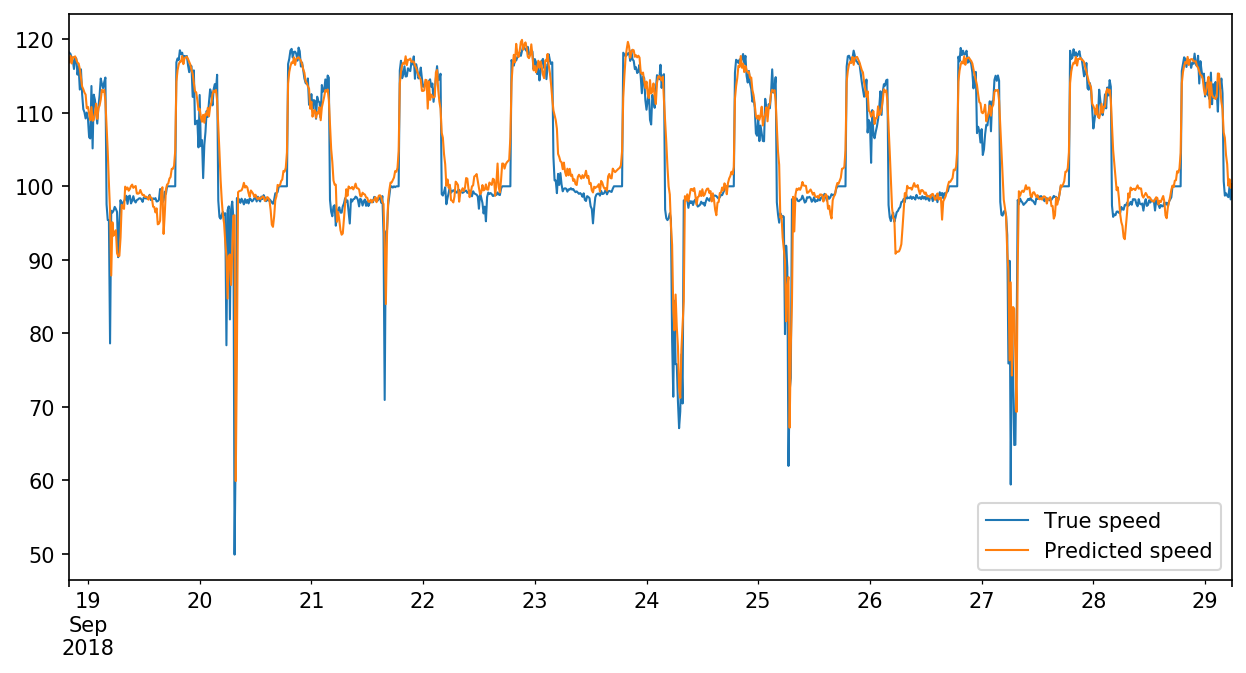

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

predictions[-10000:-9000].plot(figsize = (10,5), lw = 1)

In [0]:
#filter size, batch norm, early stopping, extra (lstm) layers), speed limit, differencing, smoothing, change regu param

In [0]:
np.mean((predictions['True speed'] - predictions['Predicted speed'])**2)

37.50075095809877

In [0]:
speed = predictions['True speed'].values
np.mean((speed[1:] - speed[:-1])**2)

21.117637879524597

In [0]:
## Min-max scaling (old stuff)
def calc_mean(df, col):
    # mean(100), mean(120)
    return df.groupby(['speed_limit'])[col].mean().values

def calc_sd(df, col):
    # sd(100), sd(120)
    return df.groupby(['speed_limit'])[col].std().values

def normalize_df(df, cols):
    copy = df.copy()
    for col in cols:
        # Find mean and sd for column
        mean100, mean120 = calc_mean(copy, col)
        sd100, sd120 = calc_sd(copy, col)
        copy[col] = np.where(copy.speed_limit == 100, (copy[col] - mean100) / sd100, (copy[col] - mean120) / sd120)
    return copy


train_norm = normalize_df(train_log, cols[:-1])
val_norm = normalize_df(val_log, cols[:-1])

train2 = train.speed.values
train2 = train2.reshape(-1, 1)

val2 = val.speed.values
val2 = val2.reshape(-1, 1)

test2 = test.speed.values
test2 = test2.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train2)

train.loc[:, 'speed'] = scaler.transform(train2)
val.loc[:, 'speed'] = scaler.transform(val2)

test_data = test.iloc[:, 0].values
test_data = np.reshape(test_data, (-1, 1))
test_data = scaler.transform(test2)